In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

import collections

from absl import app

import nest_asyncio
nest_asyncio.apply()

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from keras.backend import print_tensor

#import gower

import sys
sys.path.append("/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg")
sys.path.append("/home/tester/Desktop/TF/gower/gower")
#print(sys.path)
import simple_fedavg_tff
import gower_dist as gd


2022-06-27 04:01:55.149963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 04:01:55.149993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


['/home/tester/Desktop/TF/TFF', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/tester/venv/lib/python3.9/site-packages', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg', '/home/tester/Desktop/TF/gower/gower', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg']


In [2]:
# Training hyperparameters
TOTAL_ROUNDS = 10 #NUMBER OF TOTAL TRAINING ROUNDS
ROUNDS_PER_EVAL = 1 #HOW OFTEN TO EVALUATE
TRAIN_CLIENTS_PER_ROUND = 1 #HOW MANY CLIENTS TO SAMPLE PER ROUND
CLIENT_EPOCHS_PER_ROUND = 1 #NUMBER OF EPOCHS IN THE CLIENT TO TAKE PER ROUND
BATCH_SIZE = 64 #BATCH SIZE USED ON THE CLIENT
TEST_BATCH_SIZE = 32 #MINIBATCH SIZE OF TEST DATA
SERVER_LEARNING_RATE = 0.0001 #SERVER LEARNING RATE
CLIENT_LEARNING_RATE = 0.00001 #CLIENT LEARNING RATE
NUM_CLIENTS = 1

TRAIN_SIZE = 3000
TEST_SIZE = 1000

In [3]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv")
df.pop('type')
df.pop('ts')
df.head()



,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label
0,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
1,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,S0,...,0,0,0,-,-,-,-,-,-,0
2,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
3,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,-,-,-,0
4,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,SHR,...,0,0,0,-,-,-,bad_UDP_checksum,-,F,0


In [4]:
cat_indexs = [0, 1, 2, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41]
num_indexs = [6, 7, 8, 10, 11, 12, 13, 14, 33, 34]
#bool_indexs = []


In [5]:
# Which cols are categorical
cat_index_bool = [False] * 42
for e in cat_indexs:
    cat_index_bool[e] = True

In [6]:
# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

0.34930147513355586


In [7]:
# Balance dataset
num_anom = len(df.loc[df['label']==1])
df_anom = df.loc[df['label']==1]
df_normal = df.loc[df['label']==0]
df_normal = df_normal.sample(num_anom, replace=False)
df_concated = pd.concat([df_normal, df_anom])
balanced_data = df_concated

In [9]:
df = balanced_data

data = df.sample(TRAIN_SIZE + TEST_SIZE, random_state=21)

train_data = data.head(TRAIN_SIZE)
train_labels = train_data.pop('label')
test_data = data.tail(TEST_SIZE)
test_labels = test_data.pop('label')

labels = data.pop('label')

#np.append

In [10]:

#IID or NOIID? SPLIT DATA AMONG CLIENTS
client_id_train = np.random.choice(range(NUM_CLIENTS), size=TRAIN_SIZE, replace=True)
client_id_test = np.random.choice(range(NUM_CLIENTS), size=TEST_SIZE, replace=True)

#df['client_id'] = client_id

In [11]:
#Determine max_client_ds_size and min_client_ds_size
max_client_ds_size = -1
min_client_ds_size = len(train_data.loc[client_id_train == 0])
for id in range(0,NUM_CLIENTS):
    tmp_len = len(train_data.loc[client_id_train == id])
    if(tmp_len > max_client_ds_size):
        max_client_ds_size = tmp_len
    if(tmp_len < min_client_ds_size):
        min_client_ds_size = tmp_len

In [11]:
#TRAIN: Create a dict where keys are client ids format for tff.simulation.datasets.TestClientData
# Create distnace matrix with each clients data min_client_ds_size

train_cl_dict = {}
for id in range(0,NUM_CLIENTS):
    tmp_train_df = pd.DataFrame()
    
    tmp_features = train_data.loc[client_id_train == id]
    tmp_labels = train_labels.loc[client_id_train == id]

    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
    
    for i in range(0,min_client_ds_size):
        tmp_train_df[str(i)] = tmp_gower_mat[:,i]
    
    tmp_train_df['label'] = tmp_labels.values

    tmp_train_dict = {name: np.array(value) 
                         for name, value in tmp_train_df.items()}
    
    train_cl_dict[str(id)]=tmp_train_dict.copy()
    

In [12]:
# CREATE TEST DATASET PER CLIENT

test_cl_dict = {}

for id in range(0,NUM_CLIENTS):
    
    test_df = pd.DataFrame()
    mat = []
    labs = []

    train_instances = train_data.loc[client_id_train == id]
    test_instances = test_data.loc[client_id_test == id]

    tmp_features = pd.concat([train_instances, test_instances])
    
    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
    tmp_gower_mat = tmp_gower_mat[len(train_instances):,:min_client_ds_size]

    for i in range(0,len(tmp_gower_mat)):
        row = tmp_gower_mat[i,:]
        mat.append(np.array(row))
       
    mat = np.array(mat)

    for i in range(0,min_client_ds_size):
        test_df[str(i)] = mat[:,i]

    test_df['label'] = np.array(test_labels.loc[client_id_test == id])

    test_cl_dict[str(id)] = test_df.copy()


In [13]:
# TEST CENTRALIZED IN CLIENT 0

#cnl_test_cl_dict = {}
#test_df = pd.DataFrame()
#
#mat = []
#labs = []
#
#for id in range(0,NUM_CLIENTS):
#    train_instances = train_data.loc[client_id_train == id]
#    test_instances = test_data.loc[client_id_test == id]
#
#    tmp_features = pd.concat([train_instances, test_instances])
#    
#    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
#    tmp_gower_mat = tmp_gower_mat[len(train_instances):,:min_client_ds_size]
#
#    for i in range(0,len(tmp_gower_mat)):
#        row = tmp_gower_mat[i,:]
#        mat.append(np.array(row))
#    
#    tmp_labels = test_labels.loc[client_id_test == id]
#    
#    for l in tmp_labels:
#        labs.append(l)
#    
#labs = np.array(labs)
#mat = np.array(mat)
#    
#for i in range(0,min_client_ds_size):
#    test_df[str(i)] = mat[:,i]
#    
#test_df['label'] = labs
#
##tmp_test_dict = {name: np.array(value)
##                     for name, value in test_df.items()}
#
##cnl_test_cl_dict['0'] = tmp_test_dict.copy()
#cnl_test_cl_dict['0'] = test_df.copy()


In [14]:
#TEST SPLITED

#normal_test_cl_dict = {}
#for id in range(0,NUM_CLIENTS):
#    tmp_test_df = pd.DataFrame()
#    
#    train_instances = train_data.loc[client_id_train == id]
#    test_instances = test_data.loc[client_id_test == id]
#
#    tmp_features = pd.concat([train_instances, test_instances])
#    
#    tmp_labels = test_labels.loc[client_id_test == id]
#
#    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
#    
#    for i in range(0,min_client_ds_size):
#        tmp_test_df[str(i)] = tmp_gower_mat[len(train_instances):,i]
#    
#    tmp_test_df['label'] = tmp_labels.values
#
#    tmp_test_dict = {name: np.array(value) 
#                         for name, value in tmp_test_df.items()}
#    normal_test_cl_dict[str(id)]=tmp_test_dict.copy()

In [13]:
#CONVERT TO TFF DATASET
#netw_ds = tf.data.Dataset.from_tensor_slices((netw_features_dict, netw_labels))
#netw_ds = tf.data.Dataset.from_tensor_slices(netw_features_dict)
train_fd_ds = tff.simulation.datasets.TestClientData(train_cl_dict)
#normal_test_fd_ds = tff.simulation.datasets.TestClientData(normal_test_cl_dict)
#cnl_test_fd_ds = tff.simulation.datasets.TestClientData(cnl_test_cl_dict)





2022-06-24 10:29:36.587031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-24 10:29:36.587064: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 10:29:36.587081: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-06-24 10:29:36.587309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test FedAVG

In [14]:
#def evaluate_val(keras_model, test_dataset):
#  """Evaluate the acurracy of a keras model on a test dataset."""
#  #metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
#  metric = tf.keras.metrics.SparseCategoricalCrossentropy()
#  print(test_dataset)
#  predictions = keras_model(test_dataset['x'])
#  metric.update_state(y_true=test_dataset['y'], y_pred=predictions)
#
#  #for batch in test_dataset:
#  #  #DONT KNOW WHAT DOES
#  #  predictions = keras_model(batch['x'])
#  #  metric.update_state(y_true=batch['y'], y_pred=predictions)
#  return metric.result()

def evaluate(keras_model, test_dataset):
  """Evaluate the acurracy of a keras model on a test dataset."""
  #metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  metric = tf.keras.metrics.SparseCategoricalCrossentropy()
  for batch in test_dataset:
    #DONT KNOW WHAT DOES
    predictions = keras_model(batch['x'])
    metric.update_state(y_true=batch['y'], y_pred=predictions)
  return metric.result()

#def get_custom_dataset():
#  def element_fn(element):
#    tmp_features = []
#    for i in range(0,min_client_ds_size):
#      tmp_features.append(element[str(i)])
#    features = tf.convert_to_tensor(tmp_features, dtype=tf.float32)
#    
#    #features = tf.convert_to_tensor([element["FC1_Read_Input_Register"], element["FC2_Read_Discrete_Value"]], dtype=tf.float32)
#    #print_tensor(features)
#    return collections.OrderedDict(
#      # tf.expand_dims? ADD MORE COLUMNS
#        x=features, y=element['label'])
#
#  def preprocess_train_dataset(dataset):
#    # Use buffer_size same as the maximum client dataset size,
#    return dataset.map(element_fn).shuffle(buffer_size=max_client_ds_size).repeat(
#        count=CLIENT_EPOCHS_PER_ROUND).batch(
#            BATCH_SIZE, drop_remainder=False)
#  
#  def preprocess_validation_dataset(dataset):
#    # Use buffer_size same as the maximum client dataset size,
#    return dataset.map(element_fn)
#  
#  
#  def preprocess_test_dataset(dataset):
#    return dataset.map(element_fn).batch(
#        TEST_BATCH_SIZE, drop_remainder=False)
#  
#  netw_train = train_fd_ds.preprocess(preprocess_train_dataset)
#  #netw_val = normal_test_fd_ds.preprocess(preprocess_validation_dataset)
#  
#  netw_test = preprocess_test_dataset(
#      cnl_test_fd_ds.create_tf_dataset_from_all_clients())
#  
#  return netw_train, netw_test #netw_val

def get_custom_dataset_train():
  def element_fn(element):
    tmp_features = []
    for i in range(0,min_client_ds_size):
      tmp_features.append(element[str(i)])
    features = tf.convert_to_tensor(tmp_features, dtype=tf.float32)
    
    #features = tf.convert_to_tensor([element["FC1_Read_Input_Register"], element["FC2_Read_Discrete_Value"]], dtype=tf.float32)
    #print_tensor(features)
    return collections.OrderedDict(
      # tf.expand_dims? ADD MORE COLUMNS
        x=features, y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    return dataset.map(element_fn).shuffle(buffer_size=max_client_ds_size).repeat(
        count=CLIENT_EPOCHS_PER_ROUND).batch(
            BATCH_SIZE, drop_remainder=False)
 
  netw_train = train_fd_ds.preprocess(preprocess_train_dataset)
  
  return netw_train


def create_fedavg_model(only_digits=True):
  """The CNN model used in https://arxiv.org/abs/1602.05629.

  Args:
    only_digits: If True, uses a final layer with 10 outputs, for use with the
      digits only EMNIST dataset. If False, uses 62 outputs for the larger
      dataset.

  Returns:
    An uncompiled `tf.keras.Model`.
  """
  initializer = tf.keras.initializers.GlorotNormal(seed=5)
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(min_client_ds_size,)),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(512, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2),
    #tf.keras.layers.Dense(2, activation="relu"),
    #tf.keras.layers.Dense(32, activation="relu"),
    #tf.keras.layers.Dense(4, activation="relu"),
    #tf.keras.layers.Dense(1, activation="sigmoid"),
    tf.keras.layers.Softmax()
    ])


def server_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=SERVER_LEARNING_RATE)


def client_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=CLIENT_LEARNING_RATE)

In [15]:
train_loss_list = []

client_devices = tf.config.list_logical_devices('GPU')
server_device = tf.config.list_logical_devices('CPU')[0]
tff.backends.native.set_local_python_execution_context(
    server_tf_device=server_device, client_tf_devices=client_devices)
train_data = get_custom_dataset_train()
def tff_model_fn():
  """Constructs a fully initialized model for use in federated averaging."""
  keras_model = create_fedavg_model(only_digits=True)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  return tff.learning.from_keras_model(
      keras_model,
      loss=loss,
      metrics=metrics,
      input_spec=train_data.element_type_structure)

iterative_process = simple_fedavg_tff.build_federated_averaging_process(
    tff_model_fn, server_optimizer_fn, client_optimizer_fn)
server_state = iterative_process.initialize()
# Keras model that represents the global model we'll evaluate test data on.
keras_model = create_fedavg_model(only_digits=True)
for round_num in range(TOTAL_ROUNDS):
  sampled_clients = np.random.choice(
      train_data.client_ids,
      size=TRAIN_CLIENTS_PER_ROUND,
      replace=False)
  sampled_train_data = [
      train_data.create_tf_dataset_for_client(client)
      for client in sampled_clients
  ]
  server_state, train_metrics = iterative_process.next(
      server_state, sampled_train_data)
  print(f'Round {round_num}')
  print(f'\tTraining metrics: {train_metrics}')
  train_loss_list.append(train_metrics.get('loss'))

Round 0
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.738), ('loss', 0.5913339), ('num_examples', 3000), ('num_batches', 94)])
Round 1
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.7836667), ('loss', 0.5586796), ('num_examples', 3000), ('num_batches', 94)])
Round 2
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.79), ('loss', 0.5311307), ('num_examples', 3000), ('num_batches', 94)])
Round 3
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.8066667), ('loss', 0.5031045), ('num_examples', 3000), ('num_batches', 94)])
Round 4
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.818), ('loss', 0.4845964), ('num_examples', 3000), ('num_batches', 94)])
Round 5
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.8523333), ('loss', 0.46079114), ('num_examples', 3000), ('num_batches', 94)])
Round 6
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.8653333), ('loss', 0.44050097), 

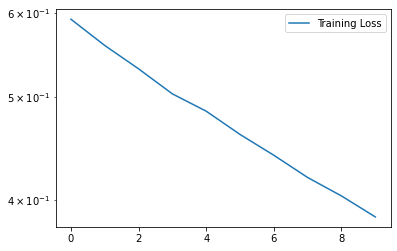

In [16]:
plt.plot(train_loss_list, label="Training Loss")
#plt.plot(val_loss_list, label="Validation Loss")
plt.yscale('log')
plt.legend()

In [ ]:
#WITH VALIDATION

#if len(argv) > 1:
#  raise app.UsageError('Too many command-line arguments.')
# If GPU is provided, TFF will by default use the first GPU like TF. The
# following lines will configure TFF to use multi-GPUs and distribute client
# computation on the GPUs. Note that we put server computatoin on CPU to avoid
# potential out of memory issue when a large number of clients is sampled per
# round. The client devices below can be an empty list when no GPU could be
# detected by TF.

#train_loss_list = []
#val_loss_list = []
#
#client_devices = tf.config.list_logical_devices('GPU')
#server_device = tf.config.list_logical_devices('CPU')[0]
#tff.backends.native.set_local_python_execution_context(
#    server_tf_device=server_device, client_tf_devices=client_devices)
#train_data, valid_data = get_custom_dataset()
#def tff_model_fn():
#  """Constructs a fully initialized model for use in federated averaging."""
#  keras_model = create_fedavg_model(only_digits=True)
#  loss = tf.keras.losses.SparseCategoricalCrossentropy()
#  #metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
#  return tff.learning.from_keras_model(
#      keras_model,
#      loss=loss,
#      #metrics=metrics,
#      input_spec=train_data.element_type_structure)
#
#iterative_process = simple_fedavg_tff.build_federated_averaging_process(
#    tff_model_fn, server_optimizer_fn, client_optimizer_fn)
#server_state = iterative_process.initialize()
## Keras model that represents the global model we'll evaluate test data on.
#keras_model = create_fedavg_model(only_digits=True)
#for round_num in range(TOTAL_ROUNDS):
#  sampled_clients = np.random.choice(
#      train_data.client_ids,
#      size=TRAIN_CLIENTS_PER_ROUND,
#      replace=False)
#  sampled_train_data = [
#      train_data.create_tf_dataset_for_client(client)
#      for client in sampled_clients
#  ]
#  server_state, train_metrics = iterative_process.next(
#      server_state, sampled_train_data)
#  print(f'Round {round_num}')
#  print(f'\tTraining metrics: {train_metrics}')
#  train_loss_list.append(train_metrics.get('loss'))
#
#  if round_num % ROUNDS_PER_EVAL == 0:
#    server_state.model.assign_weights_to(keras_model)
#    val_loss = evaluate(keras_model, valid_data)
#    val_loss_list.append(val_loss)
#    print(f'\tValidation loss: {val_loss: .7f}')

Round 0
	Training metrics: OrderedDict([('loss', 0.68399364), ('num_examples', 4744), ('num_batches', 151)])
	Validation loss:  0.6887246
Round 1
	Training metrics: OrderedDict([('loss', 0.6778889), ('num_examples', 4816), ('num_batches', 153)])
	Validation loss:  0.6846200
Round 2
	Training metrics: OrderedDict([('loss', 0.6758966), ('num_examples', 4834), ('num_batches', 155)])
	Validation loss:  0.6818887
Round 3
	Training metrics: OrderedDict([('loss', 0.6707296), ('num_examples', 4858), ('num_batches', 155)])
	Validation loss:  0.6797221
Round 4
	Training metrics: OrderedDict([('loss', 0.6707147), ('num_examples', 4878), ('num_batches', 156)])
	Validation loss:  0.6776730
Round 5
	Training metrics: OrderedDict([('loss', 0.66796565), ('num_examples', 4764), ('num_batches', 152)])
	Validation loss:  0.6756460
Round 6
	Training metrics: OrderedDict([('loss', 0.66308475), ('num_examples', 4828), ('num_batches', 154)])
	Validation loss:  0.6733381
Round 7
	Training metrics: OrderedDict

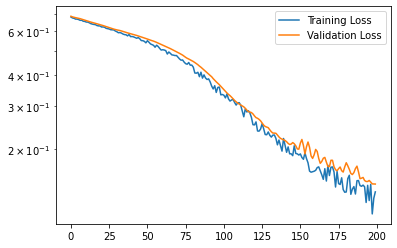

In [17]:
plt.plot(train_loss_list, label="Training Loss")
#plt.plot(val_loss_list, label="Validation Loss")
plt.yscale('log')
plt.legend()

Classify instance as abnormal if the reconstruction error is greater than the threshold

In [17]:
def predict(model, data):
  reconstructions = model(data)
  return reconstructions

def get_accuracy_list(dict):
  acc_list = []
  for i in range(0,NUM_CLIENTS):
    tmp_test = dict[str(i)].copy()
    tmp_labels = tmp_test.pop('label')
    preds = predict(keras_model, np.array(tmp_test))
    acc_list.append(accuracy_score(tmp_labels.astype(int), np.round(preds[:,1], decimals=0)))
  return acc_list
    

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))

In [18]:
acc_list = get_accuracy_list(test_cl_dict)

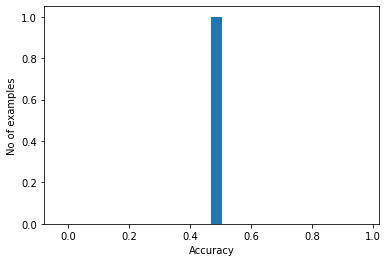

In [19]:
plt.hist(acc_list, bins=30)
plt.xlabel("Accuracy")
plt.ylabel("No of examples")
plt.show()

In [20]:
test = test_cl_dict['0'].copy()
labs = test.pop('label')
preds = predict(keras_model, np.array(test))
print_stats(np.round(preds[:,1], decimals=0), labs.astype(int))

Accuracy = 0.47
Precision = 0.0
Recall = 0.0
F1 = 0.0
ROC_AUC = 0.48057259713701433


In [21]:
tr = tmp_train_df.copy()
trlabs = tr.pop('label')
trpreds = predict(keras_model, np.array(tr))
print_stats(np.round(trpreds[:,1], decimals=0), trlabs.astype(int))

Accuracy = 0.4593333333333333
Precision = 0.0
Recall = 0.0
F1 = 0.0
ROC_AUC = 0.46522619851451724


### Centralized test

In [23]:
# Results dont make sense give more weight to anomaly class in the learning process
cnl_test = cnl_test_cl_dict['0'].copy()
cnl_labels = cnl_test.pop('label')
preds = predict(keras_model, np.array(cnl_test))

In [24]:
print_stats(np.round(preds[:,1], decimals=0), cnl_labels.astype(int))

Accuracy = 0.524
Precision = 0.5200276243093923
Recall = 0.9753886010362695
F1 = 0.6783783783783783
ROC_AUC = 0.5103591356829699


## OLD (non cnlzd test)

In [30]:
def predict(keras_model, test_dataset):
  predictions = []
  for batch in test_dataset:
    #DONT KNOW WHAT DOES
    #print(batch)
    predictions.append(keras_model(batch['x']))
  return predictions

In [31]:
preds = predict(keras_model, test_data)

In [65]:
test = normal_test_fd_ds.create_tf_dataset_from_all_clients()


In [67]:
preds = keras_model(test)

TypeError: Inputs to a layer should be tensors. Got: <FlatMapDataset element_spec={'0': TensorSpec(shape=(), dtype=tf.float32, name=None), '1': TensorSpec(shape=(), dtype=tf.float32, name=None), '2': TensorSpec(shape=(), dtype=tf.float32, name=None), '3': TensorSpec(shape=(), dtype=tf.float32, name=None), '4': TensorSpec(shape=(), dtype=tf.float32, name=None), '5': TensorSpec(shape=(), dtype=tf.float32, name=None), '6': TensorSpec(shape=(), dtype=tf.float32, name=None), '7': TensorSpec(shape=(), dtype=tf.float32, name=None), '8': TensorSpec(shape=(), dtype=tf.float32, name=None), '9': TensorSpec(shape=(), dtype=tf.float32, name=None), '10': TensorSpec(shape=(), dtype=tf.float32, name=None), '11': TensorSpec(shape=(), dtype=tf.float32, name=None), '12': TensorSpec(shape=(), dtype=tf.float32, name=None), '13': TensorSpec(shape=(), dtype=tf.float32, name=None), '14': TensorSpec(shape=(), dtype=tf.float32, name=None), '15': TensorSpec(shape=(), dtype=tf.float32, name=None), '16': TensorSpec(shape=(), dtype=tf.float32, name=None), '17': TensorSpec(shape=(), dtype=tf.float32, name=None), '18': TensorSpec(shape=(), dtype=tf.float32, name=None), '19': TensorSpec(shape=(), dtype=tf.float32, name=None), '20': TensorSpec(shape=(), dtype=tf.float32, name=None), '21': TensorSpec(shape=(), dtype=tf.float32, name=None), '22': TensorSpec(shape=(), dtype=tf.float32, name=None), '23': TensorSpec(shape=(), dtype=tf.float32, name=None), '24': TensorSpec(shape=(), dtype=tf.float32, name=None), '25': TensorSpec(shape=(), dtype=tf.float32, name=None), '26': TensorSpec(shape=(), dtype=tf.float32, name=None), '27': TensorSpec(shape=(), dtype=tf.float32, name=None), '28': TensorSpec(shape=(), dtype=tf.float32, name=None), '29': TensorSpec(shape=(), dtype=tf.float32, name=None), '30': TensorSpec(shape=(), dtype=tf.float32, name=None), '31': TensorSpec(shape=(), dtype=tf.float32, name=None), '32': TensorSpec(shape=(), dtype=tf.float32, name=None), '33': TensorSpec(shape=(), dtype=tf.float32, name=None), '34': TensorSpec(shape=(), dtype=tf.float32, name=None), '35': TensorSpec(shape=(), dtype=tf.float32, name=None), '36': TensorSpec(shape=(), dtype=tf.float32, name=None), '37': TensorSpec(shape=(), dtype=tf.float32, name=None), '38': TensorSpec(shape=(), dtype=tf.float32, name=None), '39': TensorSpec(shape=(), dtype=tf.float32, name=None), '40': TensorSpec(shape=(), dtype=tf.float32, name=None), '41': TensorSpec(shape=(), dtype=tf.float32, name=None), '42': TensorSpec(shape=(), dtype=tf.float32, name=None), '43': TensorSpec(shape=(), dtype=tf.float32, name=None), '44': TensorSpec(shape=(), dtype=tf.float32, name=None), '45': TensorSpec(shape=(), dtype=tf.float32, name=None), '46': TensorSpec(shape=(), dtype=tf.float32, name=None), '47': TensorSpec(shape=(), dtype=tf.float32, name=None), '48': TensorSpec(shape=(), dtype=tf.float32, name=None), '49': TensorSpec(shape=(), dtype=tf.float32, name=None), '50': TensorSpec(shape=(), dtype=tf.float32, name=None), '51': TensorSpec(shape=(), dtype=tf.float32, name=None), '52': TensorSpec(shape=(), dtype=tf.float32, name=None), '53': TensorSpec(shape=(), dtype=tf.float32, name=None), '54': TensorSpec(shape=(), dtype=tf.float32, name=None), '55': TensorSpec(shape=(), dtype=tf.float32, name=None), '56': TensorSpec(shape=(), dtype=tf.float32, name=None), '57': TensorSpec(shape=(), dtype=tf.float32, name=None), '58': TensorSpec(shape=(), dtype=tf.float32, name=None), '59': TensorSpec(shape=(), dtype=tf.float32, name=None), '60': TensorSpec(shape=(), dtype=tf.float32, name=None), '61': TensorSpec(shape=(), dtype=tf.float32, name=None), '62': TensorSpec(shape=(), dtype=tf.float32, name=None), '63': TensorSpec(shape=(), dtype=tf.float32, name=None), '64': TensorSpec(shape=(), dtype=tf.float32, name=None), '65': TensorSpec(shape=(), dtype=tf.float32, name=None), '66': TensorSpec(shape=(), dtype=tf.float32, name=None), '67': TensorSpec(shape=(), dtype=tf.float32, name=None), '68': TensorSpec(shape=(), dtype=tf.float32, name=None), '69': TensorSpec(shape=(), dtype=tf.float32, name=None), '70': TensorSpec(shape=(), dtype=tf.float32, name=None), '71': TensorSpec(shape=(), dtype=tf.float32, name=None), '72': TensorSpec(shape=(), dtype=tf.float32, name=None), '73': TensorSpec(shape=(), dtype=tf.float32, name=None), '74': TensorSpec(shape=(), dtype=tf.float32, name=None), '75': TensorSpec(shape=(), dtype=tf.float32, name=None), '76': TensorSpec(shape=(), dtype=tf.float32, name=None), '77': TensorSpec(shape=(), dtype=tf.float32, name=None), '78': TensorSpec(shape=(), dtype=tf.float32, name=None), '79': TensorSpec(shape=(), dtype=tf.float32, name=None), '80': TensorSpec(shape=(), dtype=tf.float32, name=None), '81': TensorSpec(shape=(), dtype=tf.float32, name=None), '82': TensorSpec(shape=(), dtype=tf.float32, name=None), '83': TensorSpec(shape=(), dtype=tf.float32, name=None), '84': TensorSpec(shape=(), dtype=tf.float32, name=None), '85': TensorSpec(shape=(), dtype=tf.float32, name=None), '86': TensorSpec(shape=(), dtype=tf.float32, name=None), '87': TensorSpec(shape=(), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [57]:
np.round(preds[:,1])

TypeError: list indices must be integers or slices, not tuple

In [56]:
# Results dont make sense give more weight to anomaly class in the learning process
preds = predict(keras_model, test_data)
print_stats(np.round(preds[:,1], decimals=0), test_labels.astype(int))

tf.Tensor([0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1], shape=(16,), dtype=int64)
tf.Tensor([0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1], shape=(16,), dtype=int64)
tf.Tensor([0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0], shape=(16,), dtype=int64)
tf.Tensor([0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1], shape=(16,), dtype=int64)
tf.Tensor([1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0], shape=(16,), dtype=int64)
tf.Tensor([1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1], shape=(16,), dtype=int64)
tf.Tensor([0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0], shape=(16,), dtype=int64)
tf.Tensor([0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1], shape=(16,), dtype=int64)
tf.Ten

TypeError: list indices must be integers or slices, not tuple